<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/SOA_talk_lognormal_scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Future greek without nested stochastics #


## Introduction ##

This jupyter notebook is used to illustrate how to calculate future Greeks without nested stochastics. 
Using a neural network to represent the future Greek is not a new idea. However, previously, we need some kind of approximation of future Greek as training target. With the technique we illustrate in the document, we don’t need to do that.

The inputs of the process are:

* One set of scenario, risk neural or real world
* Cashflows

That's it. We **don’t** need nested scenario, or even shocked scenario.

A neural network is used to represent the delta. The after hedge financial result is calculated for each scenario. The training target is to get the variance of after hedge result as small as possible.

We will use a simple call with lognormal scenarios as an example. The delta calculated by the trained neural network is extremely close to the famed Black Scholes formula. In a sense the neural network rediscovered Black Scholes formula on its own :)

Elsewhere we will have more complicated examples: AAA US equity scenario, a VA like put guarantee with high watermark, higher order hedge and CTE as training target etc.


## The training code


We recommand to run the example on Google Colab. It's free GPU!

First, make sure there is a GPU. On Google Colab, there are two type of GPU. One is Tesla K80 and the other is Tesla T4. T4 is more than twice faster than K80 for our training

In [1]:
!nvidia-smi

Wed Oct 16 15:16:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Update to the latest pytorch package. Pytorch 1.2 incorporated AdamW optimizer, which is an improvement over the regular Adam. Also LBFGS optimizer incorporates strong wolfe line search algo. LBFGS is faster but memory intensive and not as stable. Our neural network is small enough that LBFGS actually works reasonably well. The warming up with AdamW helped with the stability problem.

In [2]:
!pip3 install torch torchvision --upgrade


     |████████████████████████████████| 773.1MB 30kB/s 
     |████████████████████████████████| 10.1MB 20.7MB/s 
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0
  Found existing installation: torchvision 0.4.0
    Uninstalling torchvision-0.4.0:
      Successfully uninstalled torchvision-0.4.0


In [3]:
import torch
import numpy as np
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.3.0
cuda


### Scenarios and cashflow 


Parameters: one year (252 day) option. Daily hedging. 16% annualized volatility. The risk free rate is 2%. But the drift of the scenario is set to 0%. **The training can recover risk neural delta with real world scenario.** Depending the cashflow logic, we can manipulate the drift to line up with the strike to improve the model convergence.

In [0]:
d=252      #days of simulation
rf=0.02    #risk free rate
sigma=.16  #volatility
drift=0.0  #drift of the scenario

4 batch of 1024 scenarios. Similar result could be achieved with a much smaller set of scenarios, but not as robustly.

In [0]:
K1, K2 = 2, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

dt=torch.tensor(1/d,device=device)
sq_dt=torch.sqrt(dt)

s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
  idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)
t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                      
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]
#the chg is discounted to time zero already

Format data for training 

In [0]:
t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)

### Delta neural network model

Here is the delta neural network model.  It has two input, time to maturity and index level. There is only one output: delta. There are two middle layer of 16 and 8 nodes. The count of trainable parameter is less than 200. So it is a very small network by modern standard. The result could be improved slightly with a bigger network say two 32 node middle layers. With more than 5 times the trainable parameters, the training speed will decrease, but not by 5 times. 

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(2, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8, 1),
    torch.nn.Sigmoid(),
)

model_delta = model_delta.to(device)
#model_delta = torch.jit.script(model_delta)

### Training


We will use AdamW optimizer first. Then use LBFGS solver with strong_wolfe line search. AdamW is a more robust optimizer. Given enough time, AdamW tend to converge to a very good solution. LBFGS is a higher order optimizer and tend to converge faster when close to the optimal solution. 

In [8]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.03,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for j in range(50):
    for i in range(N1):
        optimizer.zero_grad()
        delta=model_delta(ts[i])
        delta=delta.view(N2,d)
        asset_gl=torch.sum(delta*chg[i],dim=1)
        hedged_price=asset_gl-pv_payout[i]
        loss=hedged_price.var()
        loss.backward()
        optimizer.step()    
    if j%10==0: print(j,loss.item())
t2=time.time()
print("{:.3}".format(t2-t1), " seconds")

0 0.0019234715728089213
10 0.0001642001880099997
20 8.741558849578723e-05
30 4.634910146705806e-05
40 3.325006036902778e-05
1.82  seconds


LBFGS optimizer works better less noise. So we run the LBFGS across all 4096 scenarios. 

In [9]:
optimizer = torch.optim.LBFGS(model_delta.parameters(),lr=1.0,
                             max_iter=100,line_search_fn ="strong_wolfe",
                             tolerance_grad=1e-30, tolerance_change=1e-30)

def closure():
  optimizer.zero_grad()

  delta=model_delta(ts)
  delta=delta.view(N1,N2,d)
  asset_gl=torch.sum(delta*chg,dim=2)
  hedged_price=asset_gl-pv_payout
  loss=hedged_price.var()
  loss.backward()
  return loss  

t1=time.time()
print("init",closure().item())
optimizer.step(closure)
print("lbfgs",closure().item())
t2=time.time()
print("{:.3}".format(t2-t1), " seconds")

init 2.6952617190545425e-05
lbfgs 1.2240508112881798e-05
4.96  seconds


## Comparison of neural network detla to Black Scholes delta

Standard Black Scholes formulas for call

In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

In [0]:
def norm_cdf(x):
  return torch.erfc(-x/np.sqrt(2))/2

def delta_bs_torch(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
#    pytorch version
    d1 = (torch.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * torch.sqrt(T))
    delta =  torch.exp(-q * T) * norm_cdf(d1)        
    return delta


Chart the difference

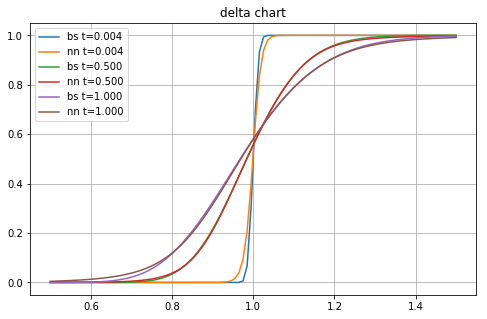

In [12]:
import matplotlib.pyplot as plt

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[.004,.5,1.0]
for tc in tl:
  sc=torch.linspace(0.5,1.5,100,device=device)
  tsc=torch.zeros((100,2),device=device)
  tsc[:,0]=tc
  tsc[:,1]=sc
  d_bs=delta_bs(sc.cpu().numpy(),1,rf,0,tc,sigma)
  d_nn=model_delta(tsc)
  plt.plot(sc.cpu().numpy(),d_bs,label="bs t="+ "%.3f" % tc)
  plt.plot(sc.cpu().numpy(),d_nn.cpu().view(100).detach().numpy(),
           label="nn t="+ "%.3f" % tc)

plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()

Typically we should see the neural network line and Black Scholes line  right on top of each other. For t=0.004 (1 day before the expiration) the slope of the delta curve(gamma) is extremely steep. Very often the neural network delta is not as steep. At t=1, the neural network only saw one index level at 1. But typically the neural network delta matches Black Scholes delta over a pretty broad region. This means the model extrapolates well and overfitting is probably not that big a problem.

##Validation

Next, we calculate the hedge effectiveness of training scenario set and a seperate validation scenario set. 

In [0]:
def print_nn_stat():
  delta=model_delta(ts)
  delta=delta.view(N1,N2,d)
  asset_gl=torch.sum(delta*chg,dim=2)
  hedged_price=asset_gl-pv_payout
  before_hedge=pv_payout.std().item()
  after_hedge=hedged_price.std().item()
  print("\n% scenario with payout: ",pv_payout.sign().mean().item())
  print("\nstd pv payout, after hedge, effectiveness")
  print("{:.3%}".format(before_hedge), "{:.3%}".format(after_hedge), \
        "{:.3%}".format(1-after_hedge/before_hedge))
  print("\nAverage, before and after hedge:")
  print("{:.3%}".format(pv_payout.mean().item()))
  print("{:.3%}".format((pv_payout-asset_gl).mean().item()))

In [0]:
def print_bs_stat():
  delta2=delta_bs_torch(s,torch.tensor(1.0),torch.tensor(0.025),torch.tensor(0.0),
                        t,torch.tensor(.16))
  delta=delta2.view(N1,N2,d)

  asset_gl=torch.sum(delta*chg,dim=2)
  hedged_price=asset_gl-pv_payout

  before_hedge=pv_payout.std().item()
  after_hedge=hedged_price.std().item()

  print("\n-------------------------------\nHedged with Black-Scholes formula")
  print("\nstd pv payout, after hedge, effectiveness")
  print("{:.3%}".format(before_hedge), "{:.3%}".format(after_hedge), \
        "{:.3%}".format(1-after_hedge/before_hedge))
  print("\nAverage, before and after hedge:")
  print("{:.3%}".format(pv_payout.mean().item()))
  print("{:.3%}".format((pv_payout-asset_gl).mean().item()))
  print("\nBlack-Scholes price:")
  print("{:.3%}".format(call_bs(1,1,0.02,0,1,.16)))

In [15]:
print_nn_stat()
print_bs_stat()


% scenario with payout:  0.468505859375

std pv payout, after hedge, effectiveness
9.994% 0.350% 96.499%

Average, before and after hedge:
6.276%
7.349%

-------------------------------
Hedged with Black-Scholes formula

std pv payout, after hedge, effectiveness
9.994% 0.359% 96.406%

Average, before and after hedge:
6.276%
7.361%

Black-Scholes price:
7.352%


Generate another set of scenario for validation

In [16]:
s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
  idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)

t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                     
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]

t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)


print_nn_stat()
print_bs_stat()



% scenario with payout:  0.462646484375

std pv payout, after hedge, effectiveness
10.185% 0.359% 96.477%

Average, before and after hedge:
6.326%
7.354%

-------------------------------
Hedged with Black-Scholes formula

std pv payout, after hedge, effectiveness
10.185% 0.366% 96.404%

Average, before and after hedge:
6.326%
7.367%

Black-Scholes price:
7.352%


Another validation set with risk neural growth

In [17]:
drift=0.02
s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
  idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)

t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                     
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]

t=torch.linspace(1,1/d,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)

print_nn_stat()
print_bs_stat()



% scenario with payout:  0.525146484375

std pv payout, after hedge, effectiveness
10.892% 0.350% 96.791%

Average, before and after hedge:
7.368%
7.359%

-------------------------------
Hedged with Black-Scholes formula

std pv payout, after hedge, effectiveness
10.892% 0.360% 96.695%

Average, before and after hedge:
7.368%
7.357%

Black-Scholes price:
7.352%


The all hedge effectiveness of validation sets are pretty close to training, at around 96.5%. This further confirms we are not overfitting to the scenarios. The hedge effectiveness is actually slightly better with the neural network delta compared to Black-Scholes formula

## Discussion

Here we studied how to use a neural network to approximate the delta of a call option over the life the option. 

The data requirement for the process is small: a single set of scenario and cash flows. And we don’t really need any prior knowledge of financial mathematics or stochastic calculus. 

The delta is solved by maximizing the hedge effectiveness of the delta hedge strategy. There are literature shows Black-Scholes formula delta will produce the highest possible hedge effectiveness when the rebalancing is continuously. The delta from the solving process is extremely close to the Black-Scholes delta. The hedge effectiveness is actually higher with neural network compared to Black-Scholes delta, probably because of the discrete natual of rebalance. 


One implication is it’s now possible calculate the delta on each node along each path, giving scenario set and cash for a block of variable annuity.

There are several considering when applying this technique to AAA scenario:
* Monthly rebalancing is not good enough a delta hedge. We need to either model a gamma hedge asset and/or an approximation of daily rebalancing. 
* Additional input to the neural network is needed for feature such as high watermark etc.
* It’s possible to add CTE as one of the optimizing target. 
* The hedge effectiveness will be lower because the randomness in the volatility is difficult to hedge. 

One limitation of the approaches are:

*  Reproducibility. Because of the natural of the neural network training technique, the resulting delta function tend to slightly different in the end. But this is partially mitigated by the similarly high hedge effectiveness, which means the slightly different delta probably doesn’t matter that much in practice.
* No intuition for individual neuron output. Only the final network output make sense.



## Conclusion

We demonstrated a method to train a neural network as a proxy of delta of financial options and discussed implication applying this method to AAA scenario and variable annuity cashflow. 